In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

from tqdm import tqdm
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

from PIL import Image

This notebook uses a pretrained (supervised) RAFT model to estimate optical flow.

The script 'cwm/models/raft/download_raft_checkpoints.sh' will download these checkpoints.

In [3]:
from cwm.models.raft.raft_model import load_raft_model
from cwm.data.utils import FlowToRgb

if not os.path.exists('../checkpoints/raft_checkpoints/'):
    os.system('../cwm/models/raft/download_raft_checkpoints.sh')

--2023-06-11 16:09:56--  https://www.dropbox.com/s/4j4z58wuv8o0mfz/models.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/4j4z58wuv8o0mfz/models.zip [following]
--2023-06-11 16:09:56--  https://www.dropbox.com/s/raw/4j4z58wuv8o0mfz/models.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc791a69872960d9b5d52485cee1.dl.dropboxusercontent.com/cd/0/inline/B9zzAYg1LbyNhDjhlbhrhykLZv2R0XfFbLg1HvvHzuIYAB9E8OjIpJPEsJbppu_5MLf7Z3CisEwXnkil37s4DXgdEHwfPO7PNK4YshjWO_jtFFxDeFuYrUdoUmvgqx65bSJnKipbf5ArYVCBg8pMzfYHPvQl3NrGkhxjn2AU8Gj5Cw/file# [following]
--2023-06-11 16:09:56--  https://uc791a69872960d9b5d52485cee1.dl.dropboxusercontent.com/cd/0/inline/B9zzAYg1LbyNhDjhlbhrhykLZv2R0XfFbLg1HvvHzuIYAB9E8OjIpJPEsJbppu_5MLf7Z3CisEwXnkil37s4DXgdEHwfPO7PNK4YshjWO_jtFFxDeF

  5000K .......... .......... .......... .......... ..........  6% 4.98M 6s
  5050K .......... .......... .......... .......... ..........  6% 19.4M 6s
  5100K .......... .......... .......... .......... ..........  6% 36.0M 6s
  5150K .......... .......... .......... .......... ..........  6% 49.6M 6s
  5200K .......... .......... .......... .......... ..........  6% 56.6M 6s
  5250K .......... .......... .......... .......... ..........  6%  233M 6s
  5300K .......... .......... .......... .......... ..........  6%  123M 6s
  5350K .......... .......... .......... .......... ..........  6% 64.1M 6s
  5400K .......... .......... .......... .......... ..........  6% 95.2M 6s
  5450K .......... .......... .......... .......... ..........  6%  174M 6s
  5500K .......... .......... .......... .......... ..........  6% 12.8M 6s
  5550K .......... .......... .......... .......... ..........  6% 2.38M 6s
  5600K .......... .......... .......... .......... ..........  7%  166M 6s
  5650K ....

 13450K .......... .......... .......... .......... .......... 16% 4.49M 4s
 13500K .......... .......... .......... .......... .......... 16% 27.2M 4s
 13550K .......... .......... .......... .......... .......... 16% 38.5M 4s
 13600K .......... .......... .......... .......... .......... 17% 41.3M 4s
 13650K .......... .......... .......... .......... .......... 17% 34.4M 4s
 13700K .......... .......... .......... .......... .......... 17% 1.85M 4s
 13750K .......... .......... .......... .......... .......... 17%  162M 4s
 13800K .......... .......... .......... .......... .......... 17% 87.2M 4s
 13850K .......... .......... .......... .......... .......... 17% 34.0M 4s
 13900K .......... .......... .......... .......... .......... 17%  177M 4s
 13950K .......... .......... .......... .......... .......... 17%  178M 4s
 14000K .......... .......... .......... .......... .......... 17%  148M 4s
 14050K .......... .......... .......... .......... .......... 17% 86.7M 4s
 14100K ....

 21800K .......... .......... .......... .......... .......... 27% 1.49M 3s
 21850K .......... .......... .......... .......... .......... 27% 33.7M 3s
 21900K .......... .......... .......... .......... .......... 27% 27.4M 3s
 21950K .......... .......... .......... .......... .......... 27% 15.2M 3s
 22000K .......... .......... .......... .......... .......... 27% 54.9M 3s
 22050K .......... .......... .......... .......... .......... 27%  172M 3s
 22100K .......... .......... .......... .......... .......... 27% 41.4M 3s
 22150K .......... .......... .......... .......... .......... 27% 19.8M 3s
 22200K .......... .......... .......... .......... .......... 27%  456M 3s
 22250K .......... .......... .......... .......... .......... 27%  568M 3s
 22300K .......... .......... .......... .......... .......... 27%  184M 3s
 22350K .......... .......... .......... .......... .......... 27% 18.2M 3s
 22400K .......... .......... .......... .......... .......... 28% 2.06M 3s
 22450K ....

 29400K .......... .......... .......... .......... .......... 36% 10.8M 3s
 29450K .......... .......... .......... .......... .......... 36%  221M 3s
 29500K .......... .......... .......... .......... .......... 36%  286M 3s
 29550K .......... .......... .......... .......... .......... 36%  313M 3s
 29600K .......... .......... .......... .......... .......... 37%  183M 3s
 29650K .......... .......... .......... .......... .......... 37%  323M 3s
 29700K .......... .......... .......... .......... .......... 37% 85.2M 3s
 29750K .......... .......... .......... .......... .......... 37% 68.6M 3s
 29800K .......... .......... .......... .......... .......... 37% 21.6M 3s
 29850K .......... .......... .......... .......... .......... 37% 2.47M 3s
 29900K .......... .......... .......... .......... .......... 37%  253M 3s
 29950K .......... .......... .......... .......... .......... 37% 62.4M 3s
 30000K .......... .......... .......... .......... .......... 37% 19.0M 3s
 30050K ....

 38850K .......... .......... .......... .......... .......... 48% 19.3M 2s
 38900K .......... .......... .......... .......... .......... 48% 21.0M 2s
 38950K .......... .......... .......... .......... .......... 48%  326M 2s
 39000K .......... .......... .......... .......... .......... 48% 6.09M 2s
 39050K .......... .......... .......... .......... .......... 48%  159M 2s
 39100K .......... .......... .......... .......... .......... 48% 71.2M 2s
 39150K .......... .......... .......... .......... .......... 48% 73.2M 2s
 39200K .......... .......... .......... .......... .......... 49% 92.1M 2s
 39250K .......... .......... .......... .......... .......... 49%  100M 2s
 39300K .......... .......... .......... .......... .......... 49% 98.4M 2s
 39350K .......... .......... .......... .......... .......... 49% 72.2M 2s
 39400K .......... .......... .......... .......... .......... 49% 95.6M 2s
 39450K .......... .......... .......... .......... .......... 49%  144M 2s
 39500K ....

 44450K .......... .......... .......... .......... .......... 55% 2.15M 2s
 44500K .......... .......... .......... .......... .......... 55% 4.32M 2s
 44550K .......... .......... .......... .......... .......... 55% 25.7M 2s
 44600K .......... .......... .......... .......... .......... 55%  209M 2s
 44650K .......... .......... .......... .......... .......... 55%  198M 2s
 44700K .......... .......... .......... .......... .......... 55% 83.0M 2s
 44750K .......... .......... .......... .......... .......... 55% 79.0M 2s
 44800K .......... .......... .......... .......... .......... 56%  135M 2s
 44850K .......... .......... .......... .......... .......... 56% 13.5M 2s
 44900K .......... .......... .......... .......... .......... 56% 9.44M 2s
 44950K .......... .......... .......... .......... .......... 56%  224M 2s
 45000K .......... .......... .......... .......... .......... 56%  270M 2s
 45050K .......... .......... .......... .......... .......... 56%  323M 2s
 45100K ....

 54550K .......... .......... .......... .......... .......... 68% 1.29M 1s
 54600K .......... .......... .......... .......... .......... 68% 23.0M 1s
 54650K .......... .......... .......... .......... .......... 68% 11.4M 1s
 54700K .......... .......... .......... .......... .......... 68% 61.3M 1s
 54750K .......... .......... .......... .......... .......... 68%  660M 1s
 54800K .......... .......... .......... .......... .......... 68% 30.9M 1s
 54850K .......... .......... .......... .......... .......... 68%  244M 1s
 54900K .......... .......... .......... .......... .......... 68% 77.8M 1s
 54950K .......... .......... .......... .......... .......... 68% 47.0M 1s
 55000K .......... .......... .......... .......... .......... 68%  118M 1s
 55050K .......... .......... .......... .......... .......... 68%  105M 1s
 55100K .......... .......... .......... .......... .......... 68%  104M 1s
 55150K .......... .......... .......... .......... .......... 68% 49.9M 1s
 55200K ....

 66300K .......... .......... .......... .......... .......... 82% 87.2M 1s
 66350K .......... .......... .......... .......... .......... 82%  250M 1s
 66400K .......... .......... .......... .......... .......... 83% 5.25M 1s
 66450K .......... .......... .......... .......... .......... 83% 3.37M 1s
 66500K .......... .......... .......... .......... .......... 83%  178M 1s
 66550K .......... .......... .......... .......... .......... 83%  248M 1s
 66600K .......... .......... .......... .......... .......... 83%  130M 1s
 66650K .......... .......... .......... .......... .......... 83%  209M 1s
 66700K .......... .......... .......... .......... .......... 83%  248M 1s
 66750K .......... .......... .......... .......... .......... 83% 17.8M 1s
 66800K .......... .......... .......... .......... .......... 83% 22.8M 1s
 66850K .......... .......... .......... .......... .......... 83%  233M 1s
 66900K .......... .......... .......... .......... .......... 83%  326M 1s
 66950K ....

 76250K .......... .......... .......... .......... .......... 95% 1.58M 0s
 76300K .......... .......... .......... .......... .......... 95%  118M 0s
 76350K .......... .......... .......... .......... .......... 95%  144M 0s
 76400K .......... .......... .......... .......... .......... 95% 35.8M 0s
 76450K .......... .......... .......... .......... .......... 95% 57.4M 0s
 76500K .......... .......... .......... .......... .......... 95%  124M 0s
 76550K .......... .......... .......... .......... .......... 95%  153M 0s
 76600K .......... .......... .......... .......... .......... 95% 69.4M 0s
 76650K .......... .......... .......... .......... .......... 95% 30.1M 0s
 76700K .......... .......... .......... .......... .......... 95%  148M 0s
 76750K .......... .......... .......... .......... .......... 95% 45.7M 0s
 76800K .......... .......... .......... .......... .......... 95%  110M 0s
 76850K .......... .......... .......... .......... .......... 96% 1.65M 0s
 76900K ....

Archive:  models.zip
   creating: models/
  inflating: models/raft-kitti.pth   
  inflating: models/raft-sintel.pth  
  inflating: models/raft-chairs.pth  
  inflating: models/raft-things.pth  
  inflating: models/raft-small.pth   
Downloaded RAFT checkpoints:
raft-large.pth
raft-small.pth


In [4]:
DEVICE = torch.device('cpu')
USE_GPU = True

if torch.cuda.is_available() and USE_GPU:
    DEVICE = torch.device('cuda:0')
elif torch.backends.mps.is_available() and USE_GPU:
    DEVICE = torch.device('mps')

In [5]:
## Load a RAFT model for predicting flow of counterfactual movies
raft = load_raft_model().to(DEVICE)

<All keys matched successfully> RAFT ../../../checkpoints/raft_checkpoints/raft-large.pth


### Load a masked predictor for generating counterfactual movies

In [6]:
## Download checkpoint for base 8x8 model
model_checkpoint_dir = os.path.expanduser('../../CounterfactualWorldModels/checkpoints')
if not os.path.exists(model_checkpoint_dir):
    os.makedirs(model_checkpoint_dir)
    
## download base 8x8 2-frame model
base8x8_url = 'https://counterfactual-world-modeling.s3.amazonaws.com/cwm_baseVMAE_224px_8x8patches_2frames.pth'
base4x4_url = 'https://counterfactual-world-modeling.s3.amazonaws.com/cwm_largeVMAE_224px_4x4patches_2frames.pth'

!wget -nc --show-progress -P $model_checkpoint_dir $base8x8_url
!wget -nc --show-progress -P $model_checkpoint_dir $base4x4_url

File ‘../../CounterfactualWorldModels/checkpoints/cwm_baseVMAE_224px_8x8patches_2frames.pth’ already there; not retrieving.

File ‘../../CounterfactualWorldModels/checkpoints/cwm_largeVMAE_224px_4x4patches_2frames.pth’ already there; not retrieving.



In [28]:
## build and load a VMAE pretrained with the temporally-factored masking policy
import cwm.models.VideoMAE.vmae as vmae

USE_FLASH_ATTENTION = False

## to use base 8x8 model, uncomment this line
model_func = vmae.base_8x8patch_2frames_1tube
model_path = os.path.join(model_checkpoint_dir, base8x8_url.split('/')[-1])

## to use large 4x4 model, uncomment this line
# model_func = vmae.large_4x4patch_2frames_1tube
# model_path = os.path.join(model_checkpoint_dir, base4x4_url.split('/')[-1])

model = model_func(use_flash_attention=(USE_FLASH_ATTENTION and ('cuda' in DEVICE.type)))
model.eval().requires_grad_(False).to(DEVICE)
print("Num parameters: %d" % sum([v.numel() for v in model.parameters()]))

did_load = model.load_state_dict(torch.load(model_path, map_location='cpu')['model'])
print(did_load, model_func.__name__, model_path, "device: %s" % DEVICE)

NUM PATCHES IN ENCODER 1568
Num parameters: 92661312
<All keys matched successfully> base_8x8patch_2frames_1tube ../../CounterfactualWorldModels/checkpoints/cwm_baseVMAE_224px_8x8patches_2frames.pth device: mps


In [29]:
'''
Create a way of generating mask inputs to the model, and wrap it for easy prediction
We call the model wrapper Psi, whose main method is making a prediction, y, via
 
      y = Psi.predict(x, mask)
      
where
     - x is a video of shape (B,2,3,*model.img_size)
     - mask is a boolean mask of shape (B, num_patches), with num_patches = np.prod(model.mask_size)
     
'''

import cwm.models.masking as masking
import cwm.models.segmentation as segmentation

MASK_RATIO = 0.99
CLUMPING_FACTOR = 1

# an object that generates temporally-factored masks. mask_ratio of the second frame is masked out.
# clumping_factor determines how much visible patches will be clumped (default 1)
mask_generator = masking.RotatedTableUniformMaskingGenerator(
    input_size=model.mask_size,
    mask_ratio=MASK_RATIO,
    clumping_factor=CLUMPING_FACTOR,
    randomize_num_visible=False,
    always_batch=True,
    seed=0
).requires_grad_(False).to(DEVICE)

# the wrapper for making predictions
Psi = segmentation.FlowGenerator(
        predictor=model, # the model function with loaded weights
        temporal_dim=2, # the base models take inputs of shape [B,3,T,H,W]; the wrapper Psi handles reshaping
        imagenet_normalize_inputs=True, # because these models were trained with normalization
        mask_generator=mask_generator, # a way of generating masks automatically if desired
        seed=0,
        flow_model=raft # set RAFT to easily evaluate flow
).requires_grad_(False).to(DEVICE)

# 
mask = mask_generator()
print("\n")
print("example mask shape: %s" % list(mask.shape))
print("number of visible patches: %d" % mask.sum().item())

No predictor weights were loaded in constructing the FlowGenerator
This is fine as long as you already loaded the weights!
set RAFT to 24 iters


example mask shape: [1, 1568]
number of visible patches: 776


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


input shape: [1, 2, 3, 224, 224]


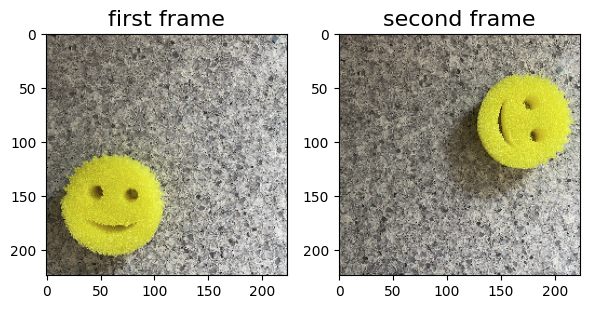

In [31]:
# create demo movie
%matplotlib inline
from cwm.vis_utils import imshow
demo_images_dir = '../../CounterfactualWorldModels/demo/images/'

img1_name = 'sponge_0.png'
img2_name = 'sponge_1.png'
img1 = Image.open(os.path.join(demo_images_dir, img1_name))
img2 = Image.open(os.path.join(demo_images_dir, img2_name))

tr = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([224,224], interpolation=transforms.InterpolationMode.BICUBIC),
])

x = torch.stack([tr(_img)[0:3] for _img in (img1, img2)], 0)[None].to(DEVICE)
print("input shape: %s" % list(x.shape))

fig, axes = plt.subplots(1,2,figsize=(6,3))
imshow(x, t=0, ax=axes[0], title='first frame', fontsize=16)
imshow(x, t=1, ax=axes[1], title='second frame', fontsize=16)
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


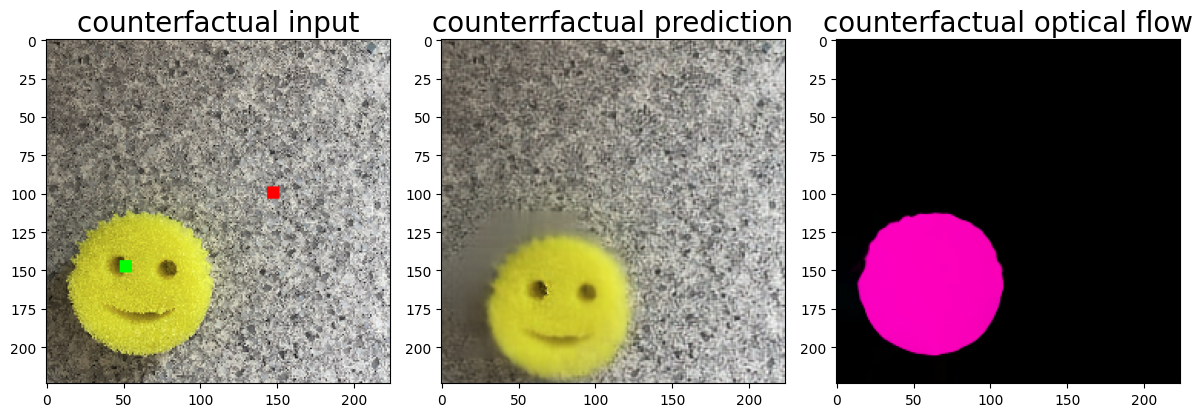

In [32]:
%matplotlib inline
'''
Counterfactual predictions are made by calling
   y_cf = Psi.get_counterfactual_prediction(x, mask, active_patches, shift)
   
   where 
      - x is the image input; if a movie, first frame used
      - active_patches are the patches to be moved
      - mask are the patches to be kept static
      - shift is a 2-list of the motion counterfactual direction (in patch widths)
'''

shift = [2, 2]
active_locs = [ [150, 50] ]
passive_locs = [ [100, 150] ]

Psi.set_input(x)
active_mask = Psi.generate_mask_from_patch_idx_list(active_locs)
passive_mask = Psi.generate_mask_from_patch_idx_list(passive_locs)

y_cf = Psi.get_counterfactual_prediction(x[:,0],
                                         mask=passive_mask,
                                         active_patches=active_mask,
                                         shift=shift,
                                         fix_passive=False # this will make sure only first frame of x is used
                                        )

x_cf = Psi.get_masked_pred_patches(
    Psi.make_static_movie(x[:,0:1], T=2),
    mask=active_mask, invert=False,
    fill_value=[0,1,0]
)
x_cf = Psi.get_masked_pred_patches(
    x_cf,
    mask=passive_mask, invert=False,
    fill_value=[1,0,0]
)
flow_cf = Psi.predict_flow(y_cf)

fig, axes = plt.subplots(1,3,figsize=(12,4))
imshow(x_cf[:,1], ax=axes[0], title='counterfactual input')
imshow(y_cf[:,1], ax=axes[1], title='counterrfactual prediction')
Psi.flowshow(flow_cf, ax=axes[2], title='counterfactual optical flow')

plt.tight_layout()
plt.show()                                        

### Look at flow and segments using interactive visualizer

In [11]:
def load_img(file_name, crop_size=None, size=[224, 224], device='cpu'):
    img = Image.open(file_name)
    img = np.array(img)
    tr = transforms.Compose([
        transforms.ToTensor(),
        (transforms.CenterCrop(crop_size) if crop_size is not None else torch.nn.Identity()),
        transforms.Resize(size, interpolation=transforms.InterpolationMode.BICUBIC),
    ])

    vid = torch.stack([tr(_img)[0:3] for _img in (img, img)], 0)[None].to(device)    
    return vid

In [27]:
# set this to some place you have e.g. images from your smartphone
demo_images_dir = '../../datasets/home_images/'
!ls $demo_images_dir

eggs.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.image.AxesImage at 0x2901d3e50>, <Axes: >)

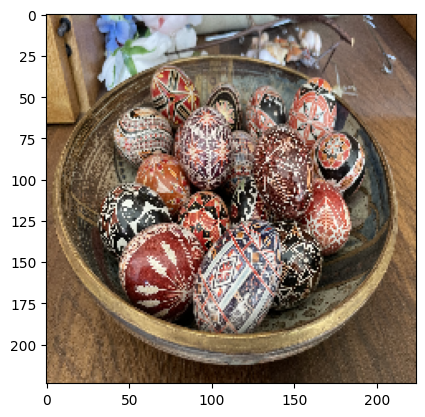

In [23]:
%matplotlib inline
x = load_img(os.path.join(demo_images_dir, 'eggs.png'), crop_size=None, device='mps')
imshow(x, t=0)


Create motion counterfactuals.

> click: place an active patch that will move by some integer number of patch widths
> right (or Command)-click: place a passive patch that will remain fixed in place
> CTRL or F-click: run the motion counterfactual with selected patches. Motion vector will be chosen randomly
> hold-D and drag: set the direction of the motion counterfactual; active patches will change color to indicate this
> SHIFT-click: reset the chosen patches



<IPython.core.display.Javascript object>


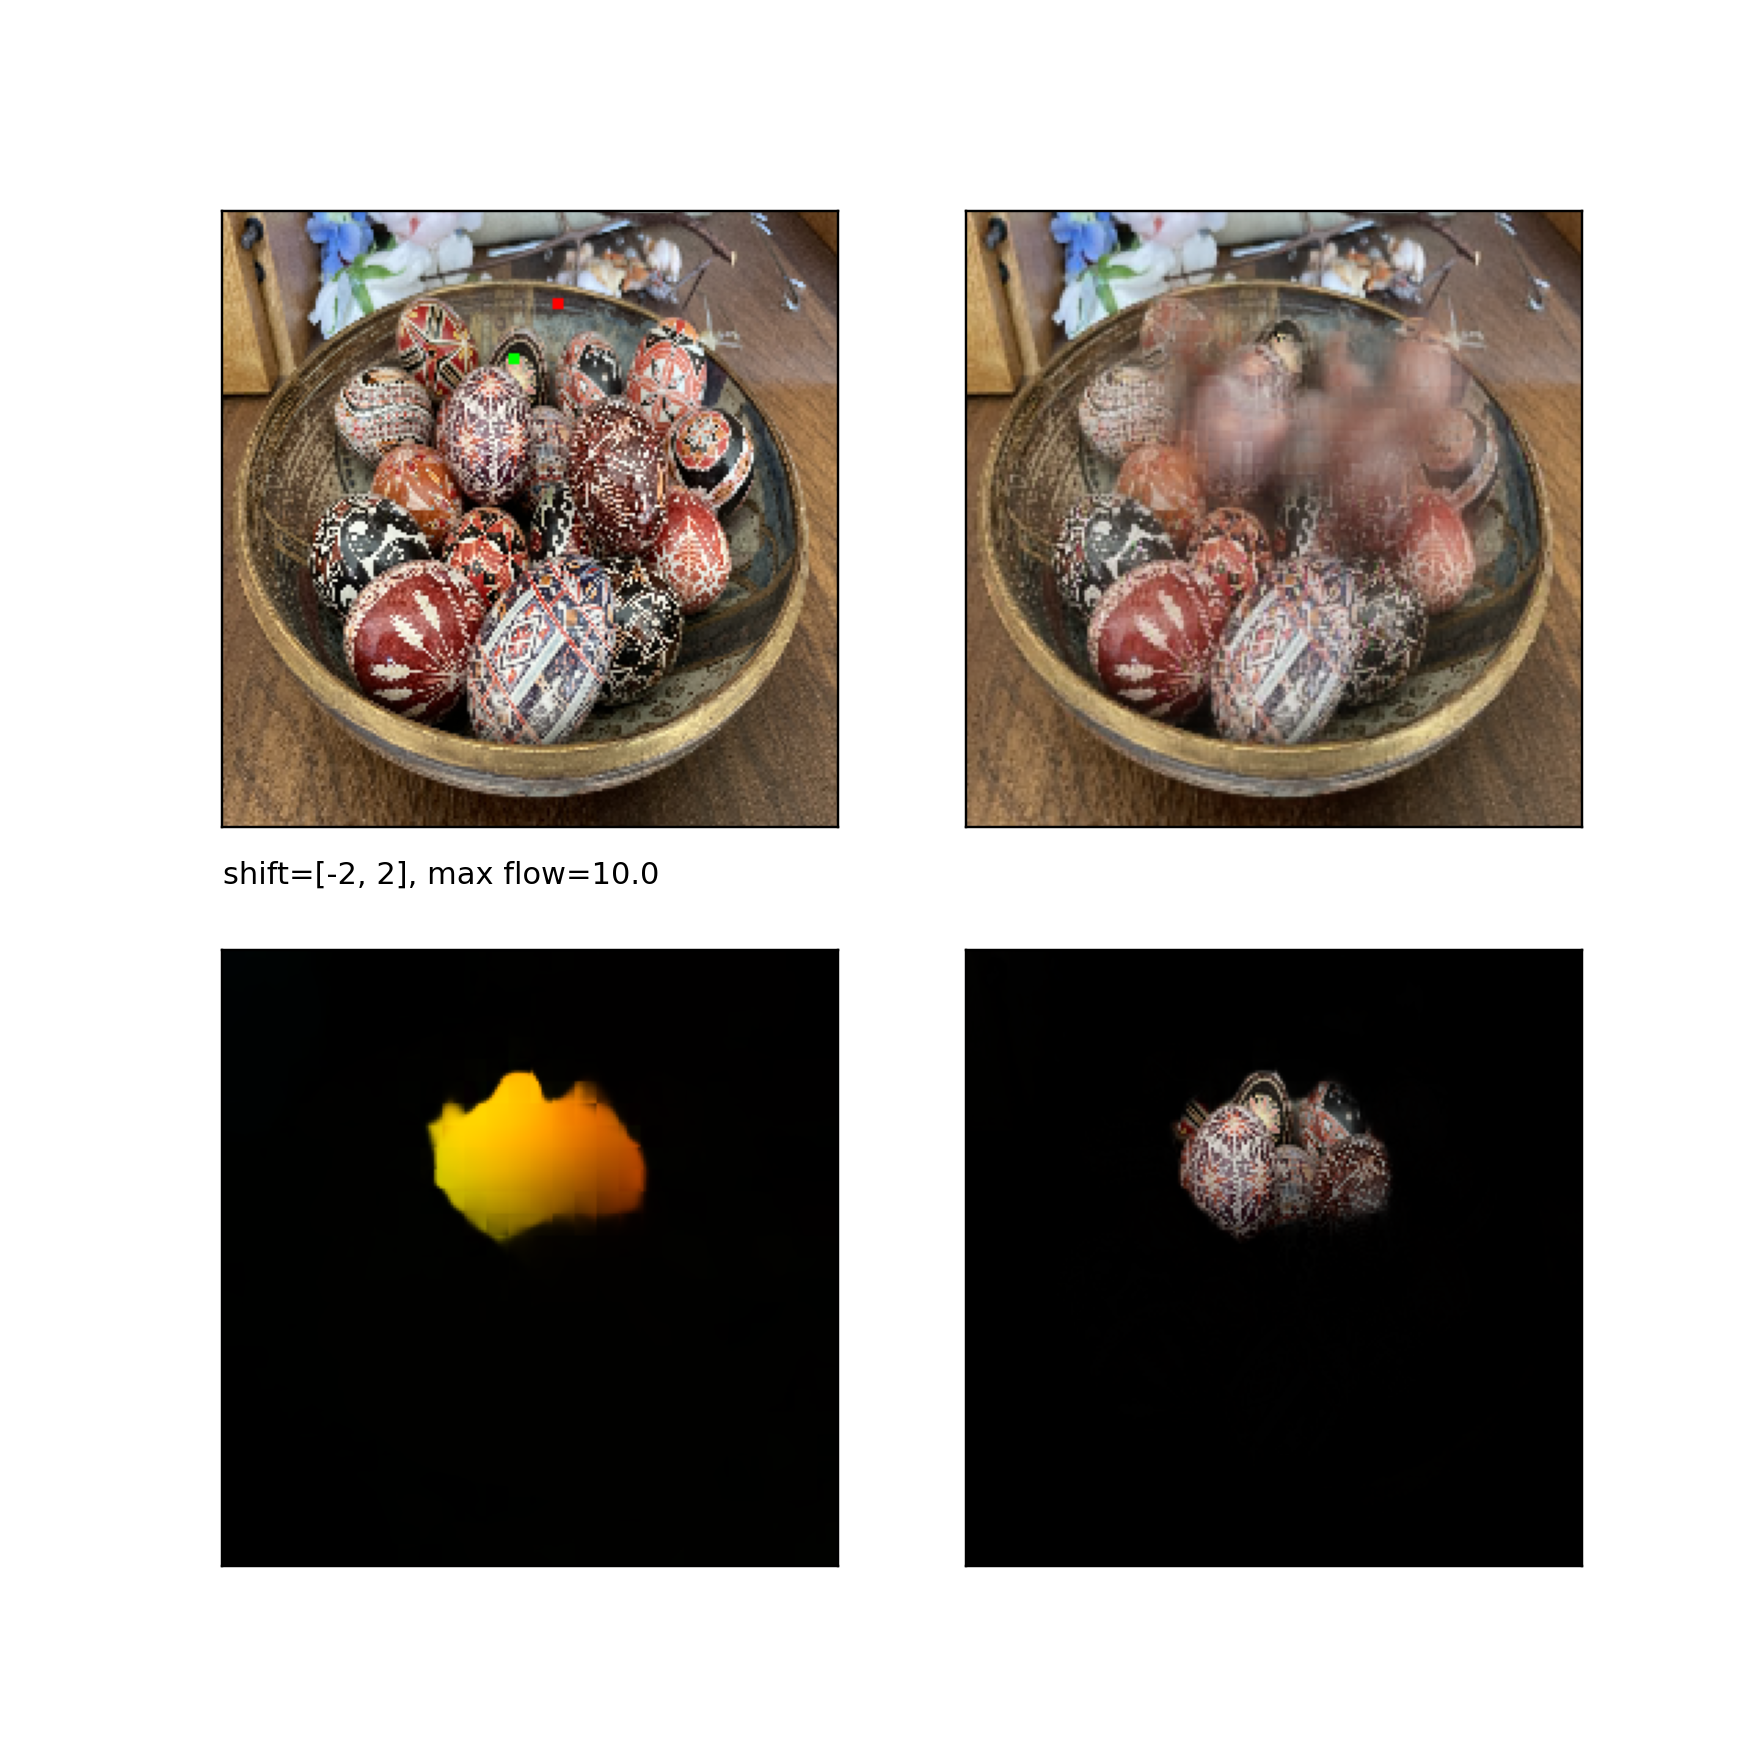

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [26]:
%matplotlib notebook
import cwm.interface as interface

docstr = '''
Create motion counterfactuals.

> click: place an active patch that will move by some integer number of patch widths
> right (or Command)-click: place a passive patch that will remain fixed in place
> CTRL or F-click: run the motion counterfactual with selected patches. Motion vector will be chosen randomly
> hold-D and drag: set the direction of the motion counterfactual; active patches will change color to indicate this
> SHIFT-click: reset the chosen patches
'''

print(docstr)

fig, axes = plt.subplots(2, 2, figsize=(8,8))
I = interface.CounterfactualPredictionInterface(
    axes=axes,
    G=Psi,
    x=x,
    device=x.device,
    active_color=[0, 1, 0],
    passive_color=[1, 0, 0],
    max_shift=3,
    show_ticks=False
)



### Multiple motion counterfactuals in parallel

In [124]:
y_mc, flow_mc = Psi.predict_counterfactual_videos_and_flows(
    x,
    active_patches=active_mask,
    passive_patches=passive_mask,
    shifts=[[1, 1], [-1, -1], [1, -1], [-1, 1]],
    num_samples=8,
    sample_batch_size=4
)


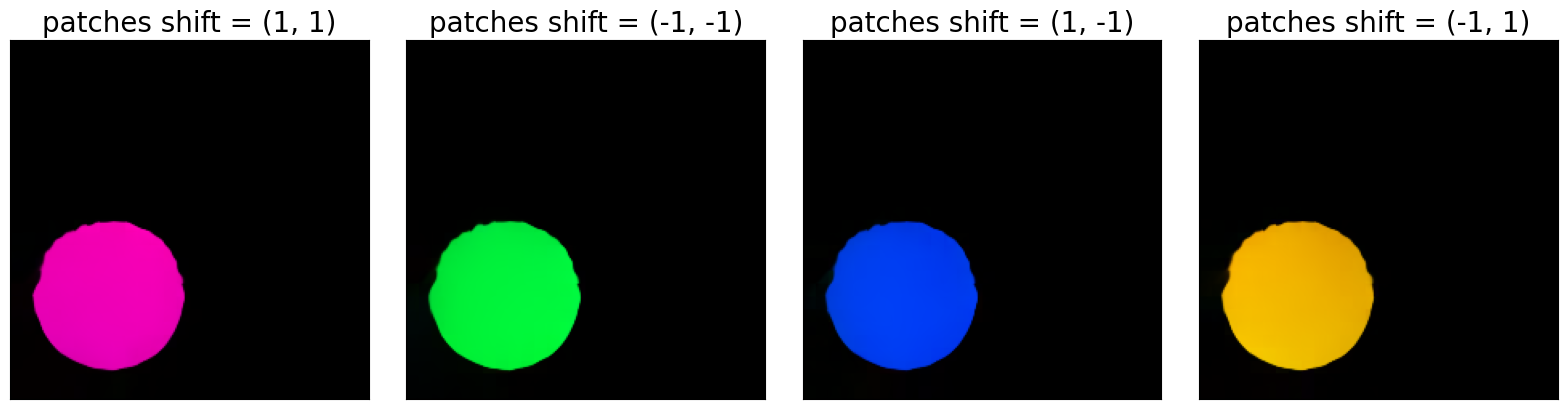

In [125]:
fig, axes = plt.subplots(1,4,figsize=(16,4))
for i, ax in enumerate(axes):
    Psi.flowshow(flow_mc[i], set_max_speed=(i == 0), ax=ax, 
                 title="patches shift = (%d, %d)" % (Psi.shifts[i][0], Psi.shifts[i][1]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()